# Custom filtering and clustering

This notebook shows how you can do custom filtering and clustering.

There are two ways to run this notebook:

- As a web server for **biologists**, using the example filters and clustering methods provided here.

- As a starting point for **bioinformaticians**, to create their own filters and/or clustering methods.


## Instructions for biologists (non-programmers)

You should run this notebook in [Google Colab](https://colab.google.com).

The notebook will download the ProtNAff RNA fragment library (trinucleotides), then apply a filtering step, and finally cluster the filtered fragments. 
In the *User parameters* section below, choose:

- A filtering method.

- A clustering method. 

- A clustering RMSD threshold (in angstroms).

- A secondary clustering RMSD threshold. This threshold is used only by the hierarchical method and should be slightly (~1 angstrom) higher than the primary threshold.

The filtering methods should be considered as proof-of-principle examples, to be extended by bioinformaticians using this notebook. The filters select purely single-stranded RNA fragments and/or fragments from NMR structures.

Three clustering methods are available. 

The "full matrix" method gives the fewest clusters, but is limited to 20 000 fragments. 

The "fast" method gives more clusters, but has no limitation. 

The "hierarchical" method combines the two, and is very close to the approach in the main ProtNAff pipeline.

**After filling in the parameters, in the Colab menu, select *Runtime => Run all cells***


## Instructions for bioinformaticians

You can run this notebook either in [Google Colab](https://colab.google.com) or under your own Jupyter instance.

In this notebook:

- A number of filters are defined, and cataloged in the "filters" dictionary.

- A number of clustering methods are defined, and cataloged in the "clustering_methods" dictionary.


### You can select a filter and a clustering method and apply it on the ProtNAff fragment library.

In "User parameters", you can select:
- One filter, among the cataloged filters.
- One clustering method, among the cataloged clustering methods.
- The clustering RMSD threshold.
- A secondary clustering RMSD threshold (if hierarchical clustering is chosen)

The ProtNAff RNA fragment library is downloaded and loaded in memory. 

Filtering and clustering is then performed on the fragment library.

The number of clusters per motif is shown, and the size distribution of the clusters is plotted.


### You can create your own filter

- The example filters are based on mask functions. Two example mask functions are provided: one to select NMR fragments, and one to select only purely single-stranded RNA fragments. You can use these examples to write your own mask functions.

- The example filter functions show how to invoke and combine mask functions. You can use this to write your own filter function. Catalog your filter function in the "filters" dictionary.

### You can create your own clustering

- Three example clustering functions are provided, based on the ones used in the ProtNAff pipeline. You can write your own clustering function based on this. A clustering function is expected to designate some of the clustered fragments as 
- The downloaded fragment library coordinates contain trinucleotide xyz values, fitted on a common reference (the first structure), with clashing fragments removed.

# Definition of example filters and clustering methods

## Fragment library definition (before loading)

These are global variables used in the filters. "motifs" is also used in clustering

In [12]:
#@title
motifs = ["AAA", "AAC", "ACA", "ACC", "CAA", "CAC", "CCA", "CCC"]
try:
    structures
except NameError:
    structures = None
    fragments = None
    coordinates = None
    rev_fragindex = None  # to map a key in fragments dict to an index in the fragment array

## Masks for filtering

In [13]:
#@title
def mask_pure_ss(motif_fragments,structures, motif_rev_fragindex):
    """Returns a mask that indicates for each fragment 
if it is purely single-stranded or not"""
    ss_set = set(["L", "T", "S", "J", "B", "I"])
    
    reverse_mapping = {}
    for strucname, structure in structures.items():
        struc_rev_mapping = {}
        for chain, mapping in structure["mapping"].items():
            struc_rev_mapping[chain] = {v:k for k,v in mapping.items()}
        reverse_mapping[strucname] = struc_rev_mapping
    
    result = np.zeros(len(motif_rev_fragindex),bool)

    for fragkey, frag in motif_fragments.items():
        if fragkey not in motif_rev_fragindex:
            # fragment contains clashes
            continue
        fragind = motif_rev_fragindex[fragkey]
        structure = frag["structure"]
        chain = frag["chain"]
        rmap = reverse_mapping[structure]["chain_" + chain]
        res = [rmap[resid] for resid in frag["resid"]]
        ss_states = structures[structure]["ss"]["chain_" + chain]
        frag_ss_states = [ss_states["res_"+ r][0] for r in res]
        is_pure_ss = all([ss_state in ss_set for ss_state in frag_ss_states])
        result[fragind] = is_pure_ss

    return result


def mask_nmr(motif_fragments,structures, motif_rev_fragindex):
    """Returns a mask that indicates for each fragment 
if it comes from NMR or not"""
    result = np.zeros(len(motif_rev_fragindex),bool)

    for fragkey, frag in motif_fragments.items():
        if fragkey not in motif_rev_fragindex:
            # fragment contains clashes
            continue
        fragind = motif_rev_fragindex[fragkey]
        structure = frag["structure"]
        struc = structures[structure]
        is_nmr = (struc["method"].find("nmr") > -1)
        result[fragind] = is_nmr
    
    return result

## Mask-based filters

In [14]:
#@title
def filter_pure_ss():
    result = {}
    for motif in fragments:
        frags = fragments[motif]
        mask = mask_pure_ss(frags, structures, rev_fragindex[motif])
        result[motif] = coordinates[motif][mask]
    return result

def filter_pure_ss_nmr():
    result = {}
    for motif in fragments:
        frags = fragments[motif]
        args = frags, structures, rev_fragindex[motif]
        mask1 = mask_pure_ss(*args)
        mask2 = mask_nmr(*args)
        mask = mask1 & mask2
        result[motif] = coordinates[motif][mask]
    return result

def filter_pure_ss_not_nmr():
    result = {}
    for motif in fragments:
        frags = fragments[motif]
        args = frags, structures, rev_fragindex[motif]
        mask1 = mask_pure_ss(*args)
        mask2 = mask_nmr(*args)
        mask = mask1 & (~mask2)
        result[motif] = coordinates[motif][mask]
    return result

def filter_none():
    return coordinates

filters = {
    "None": filter_none,
    "Pure single-stranded": filter_pure_ss,
    "Pure single-stranded, only NMR structures": filter_pure_ss_nmr,
    "Pure single-stranded, no NMR structures": filter_pure_ss_not_nmr,
}


## Clustering methods

In [15]:
#@title
def reassign(structures, clustids, chunksize):
    """Reassigns structures to the closest cluster center.
    Cluster centers are supplied in the form of cluster IDs, i.e.
    a list of integer IDs where each ID is the index of the cluster center.
    For example, [0, 3, 5] defines three cluster centers, the 1st 4th and 5th structure

    chunksize: number of structures to put in a chunk
        This is an implementation detail that only affects the speed, not the result
    """
    if len(structures.shape) == 3:
        assert structures.shape[2] == 3
        structures = structures.reshape(structures.shape[0], structures.shape[1]*3)
    if len(structures.shape) == 2:
        assert structures.shape[1] % 3 == 0

    clusters = {a:[a] for a in clustids}
    clus = structures[clustids]
    for n in range(0, len(structures), chunksize):
        chunk = structures[n:n+chunksize]
        d = chunk[:, np.newaxis, :] - clus[np.newaxis, :, :]
        inter_sd = np.einsum("...ij,...ij->...i", d,d)
        best = np.argmin(inter_sd, axis=1)
        for nn in range(len(chunk)):
            bestclust = clustids[best[nn]]
            if bestclust == (n+nn):
                continue
            clusters[bestclust].append(n+nn)
    return clusters

def cluster(structures, threshold, **kwargs):
    """Clusters structures using an RMSD threshold
        First, calculates the full pairwise RMSD matrix.
        The maximum number of structures is fixed at 20 000 (400 million pairwise RMSDs)
        
        The structure with the largest number of other structures within the RMSD
         threshold becomes a cluster.
        That structure and all of those other structures are removed.
        The process is repeated until no structures are left.

    This algorithm is used in ATTRACT and in the ProtNAff pipeline 
    (./create_frag_library/cluster-npy.py)
    """
    if len(structures.shape) == 3:
        assert structures.shape[2] == 3
        structures = structures.reshape(structures.shape[0], structures.shape[1]*3)
    if len(structures.shape) == 2:
        assert structures.shape[1] % 3 == 0

    if len(structures) > 20000:
        raise ValueError("Number of structures is too large, maximum is 20 000")

    dist = pdist(structures, 'sqeuclidean')
    d = squareform(dist)
    lim = threshold*threshold*structures.shape[1]/3
    d2 = d<lim
    del d

    clustids = []
    clustered = 0
    while clustered < len(structures):
        neigh = d2.sum(axis=0)
        cluster_center = neigh.argmax()
        clustids.append(cluster_center)
        cluster = np.where(d2[cluster_center])[0]
        for cs in cluster:
            d2[cs,:] = False
            d2[:, cs] = False
        clustered += len(cluster)
    return clustids

def fastcluster(structures, threshold, chunksize, existing=[], **kwargs):
    """Clusters structures using an RMSD threshold
        First structure becomes a cluster,
         second structure only if it doesn't cluster with the first, etc.

        structures: 2D numpy array, second dimension = 3 * natoms
          structures must already have been fitted!
        threshold: RMSD threshold (A)
        existing: a list of existing cluster IDs
        chunksize: number of structures to put in a chunk
          This is an implementation detail that only affects the speed, not the result
    
    This algorithm is used in ATTRACT and in the ProtNAff pipeline 
    (./create_frag_library/fastcluster_npy.py)
    """
    if len(structures.shape) == 3:
        assert structures.shape[2] == 3
        structures = structures.reshape(structures.shape[0], structures.shape[1]*3)
    if len(structures.shape) == 2:
        assert structures.shape[1] % 3 == 0
    natoms = structures.shape[1]/3
    # threshold2 = sum-of-sd threshold = (RMSD threshold **2) * natoms
    threshold2 = threshold**2 * natoms

    nclus = 1
    if len(existing):
        clus_space = max(len(existing), 100)
        clus = np.zeros((clus_space, structures.shape[1]))
        clus[:len(existing)] = structures[existing]
        clustids = []
        clustids[:] = existing[:]
    else:
        clus_space = 100
        clus = np.zeros((clus_space, structures.shape[1]))
        clus[:1] = structures[:1]
        clustids = [0]
    for n in range(1, len(structures), chunksize):
        #print("{0}/{1}".format(n, len(structures), file=sys.stderr)
        #sys.stderr.flush()
        chunk = structures[n:n+chunksize]
        d = chunk[:, np.newaxis, :] - clus[np.newaxis, :, :]
        inter_sd = np.einsum("...ij,...ij->...i", d, d)
        #close_inter is a 2D Boolean matrix:
        #  True  (1): chunk[i] is close to (within RMSD threshold of) clus[j]
        #  False (0): chunk[i] is not close to clus[j]
        close_inter = (inter_sd < threshold2)
        # newclustered contains all structures in the chunk that *don't* cluster with an existing cluster
        newclustered = []
        for chunk_index, closest_inter in enumerate(np.argmax(close_inter,axis=1)):
            # closest_inter contains the *first* index of close_inter
            #   with the highest value of close_inter
            # We are interested in the case where close_inter is all False (=> new cluster)
            # In that case, the highest value of close_inter is False, and closest_inter is 0
            # If close_inter is *not* all False (=> existing cluster), one of these conditions is False
            if closest_inter == 0 and close_inter[chunk_index, 0] == False:
                newclustered.append(chunk_index)

        if len(newclustered):
            # Now we have newclustered: the *chunk* index of all structures in the chunk that will be in new clusters
            # Now we want to cluster them among themselves, and add the *structure* id of each new cluster
            chunk_newclustered = chunk[newclustered]
            d = chunk_newclustered[:, np.newaxis, :] - chunk_newclustered[np.newaxis, :, :]
            intra_sd = np.einsum("...ij,...ij->...i", d, d)
            close_intra = (intra_sd < threshold2)

            # set all upper-triangular indices to False
            close_intra[np.triu_indices(len(chunk_newclustered))] = 0
            for nn in range(len(chunk_newclustered)):
                # same logic as for closest_inter;
                #  except that we don't have the chunk index, but the chunk_newclustered index (nn)
                #  and, since we modify close_intra in the "else" clause, argmax is computed later
                closest_intra = np.argmax(close_intra[nn])
                if closest_intra == 0 and close_intra[nn, 0] == False:
                    chunk_index = newclustered[nn]
                    # if clus is full, re-allocate it as a 50 % larger array
                    if nclus == clus_space:
                        clus_space = int(clus_space*1.5)
                        clus_old = clus
                        clus = np.zeros((clus_space, structures.shape[1]))
                        clus[:nclus] = clus_old
                    clus[nclus] = chunk[chunk_index]
                    clustids.append(n+chunk_index)
                    nclus += 1
                else:  # in addition, if we aren't a new cluster, being close to us doesn't matter
                    close_intra[:, nn] = False

    return clustids

def hierarchical_cluster(structures,threshold, secondary_threshold, chunksize, **kwargs):
    """Clusters structures using an RMSD threshold
    Does an initial clustering using fastcluster() with a secondary threshold
     then the resulting clusters are clustered using cluster()
    
    This is very close to the approach of the ProtNAff pipeline
    (./create_frag_library/clusterfrag_npy.sh)
    """
    if secondary_threshold <= threshold:
        raise ValueError("Secondary threshold must be higher than clustering threshold")
    chunksize = 200
    initial_clustids = fastcluster(structures,secondary_threshold,chunksize=chunksize)
    initial_clusters = reassign(structures, initial_clustids, chunksize=chunksize)
    all_rough_clustids = []
    for initial_cluster in initial_clusters.values():
        if len(initial_cluster) > 20000:
            raise ValueError("Initial cluster is too large, maximum is 20 000. Increase secondary RMSD threshold.")
        initial_cluster = np.array(initial_cluster)
        initial_cluster_struc = structures[initial_cluster]
        subclustids0 = cluster(initial_cluster_struc, threshold)
        subclustids = initial_cluster[subclustids0]
        all_rough_clustids.append(subclustids)
    rough_clustids = np.concatenate(all_rough_clustids)
    rough_clust_struc = structures[rough_clustids]
    if len(rough_clustids) > 20000:
        clustids0 = fastcluster(rough_clust_struc, threshold, chunksize=chunksize)
    else:
        clustids0 = cluster(rough_clust_struc, threshold)
    fine_clustids = rough_clustids[clustids0].tolist()
    final_clustids = fastcluster(structures, threshold, chunksize=chunksize, existing=fine_clustids)
    return final_clustids    

clustering_methods = {
    "Fast": fastcluster,
    "Full matrix": cluster,
    "Hierarchical": hierarchical_cluster,
}

# User parameters

In [16]:
filtering_method = "Pure single-stranded, no NMR structures" #@param ["None", "Pure single-stranded", "Pure single-stranded, only NMR structures", "Pure single-stranded, no NMR structures"]
clustering_method = "Hierarchical" #@param ["Fast", "Full matrix", "Hierarchical"]
clustering_threshold = 2.0 #@param {type:"slider", min:0.1, max:10, step:0.1}
secondary_threshold = 4.0 #@param {type:"slider", min:0.1, max:10, step:0.1}
chunksize = 200  # affects only the speed, not the result

## Parameter validation

In [17]:
#@title
if filtering_method not in filters:
    raise ValueError("Filtering method '{}' not in {}".format(filtering_method, filters.keys()))
if clustering_method not in clustering_methods:
    raise ValueError("Clustering method '{}' not in {}".format(clustering_method, clustering_methods.keys()))
clustering_threshold = float(clustering_threshold)
if clustering_threshold <= 0:
    raise ValueError("Clustering threshold must be positive")
secondary_threshold = float(secondary_threshold)
chunksize = int(chunksize)
if chunksize <= 0:
    raise ValueError("Chunk size must be positive")

# Execution

## Imports

In [18]:
#@title
import os
import tempfile
import shutil
import json
import numpy as np
from scipy.spatial.distance import pdist, squareform
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## Loading fragment library

In [19]:
#@title
fraglib_files = {
    "structures.json": "https://zenodo.org/record/6475637/files/structures.json",

    "fragments_clust.json": "https://zenodo.org/record/6475637/files/fragments_clust.json",

    "aa-fit.tgz": "https://zenodo.org/record/6475637/files/aa-fit.tgz",  
    # containing:
    #   <motif>-aa-fit.npy
    #   <motif>-aa.noclash
    #   for 8 motifs (AAA to CCC)
    # These come from the trilib/ directory.
    # The .npy contains only the non-clashing fragments
}

if structures is None:
    with tempfile.TemporaryDirectory() as TEMPDIR:
        for fraglib_file, url in fraglib_files.items():
            dest = os.path.join(TEMPDIR, fraglib_file)
            print("Download", url, "... ", end="")
            urlretrieve(url, dest)
            print("Done")
        os.system("cd {}; tar xzf aa-fit.tgz".format(TEMPDIR))

        structures = json.load(open(os.path.join(TEMPDIR, "structures.json")))
        fragments = json.load(open(os.path.join(TEMPDIR, "fragments_clust.json")))
        coordinates = {}
        rev_fragindex = {}
        for motif in motifs:
            coorfile = "{}-aa-fit.npy".format(motif)
            coordinates[motif] = np.load(os.path.join(TEMPDIR, coorfile))
            noclash_file = "{}-aa.noclash".format(motif)
            motif_rev_fragindex = {}
            with open(os.path.join(TEMPDIR, noclash_file)) as f:
                for lnr, l in enumerate(f.readlines()):
                    frag_key = l.strip()
                    motif_rev_fragindex[frag_key] = lnr
                assert len(motif_rev_fragindex) == len(coordinates[motif]), (len(motif_rev_fragindex), noclash_file, len(coordinates[motif]), coorfile)
                rev_fragindex[motif] = motif_rev_fragindex


## Run filtering and clustering

In [20]:
#@title
filt = filters[filtering_method]
clustering_func = clustering_methods[clustering_method]
filtered_coordinates = filt()
clusters = {}
for motif in motifs:
    print("Motif {}, filtering... ".format(motif),end="")
    motif_coors = filtered_coordinates[motif]
    print("clustering... ", end="")
    motif_clustids = clustering_func(
        motif_coors,
        threshold=clustering_threshold,
        secondary_threshold=secondary_threshold,
        chunksize=chunksize
    )
    motif_clusters = reassign(
        motif_coors,
        motif_clustids,
        chunksize=chunksize
    )
    print("Done")
    clusters[motif] = motif_clusters

Motif AAA, filtering... clustering... Done
Motif AAC, filtering... clustering... Done
Motif ACA, filtering... clustering... Done
Motif ACC, filtering... clustering... Done
Motif CAA, filtering... clustering... Done
Motif CAC, filtering... clustering... Done
Motif CCA, filtering... clustering... Done
Motif CCC, filtering... clustering... Done


# Results

## Number of clusters per motif

AAA 857
AAC 675
ACA 580
ACC 641
CAA 649
CAC 435
CCA 669
CCC 1003


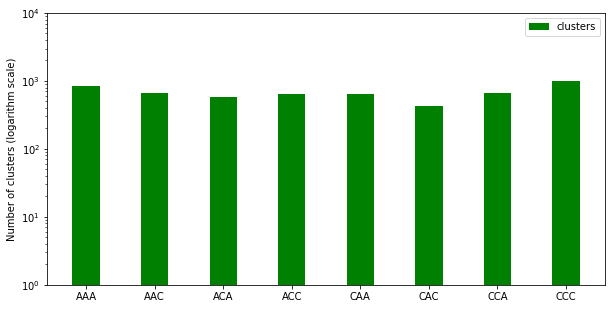

In [21]:
#@title
from math import log10, ceil

nclusts = []
for motif in motifs:
    nclust = len(clusters[motif])
    print(motif, nclust)
    nclusts.append(nclust)
plt.figure(figsize=(10,5))
plt.bar([1, 2, 3, 4, 5, 6, 7, 8], nclusts, 0.4, label="clusters", log=True, color='green')
plt.ylabel("Number of clusters (logarithm scale)")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], motifs)
ylim = 10**(ceil(log10(max(nclusts)+1)))
plt.ylim(1, ylim)
plt.legend()
plt.show()

## Distribution of cluster sizes

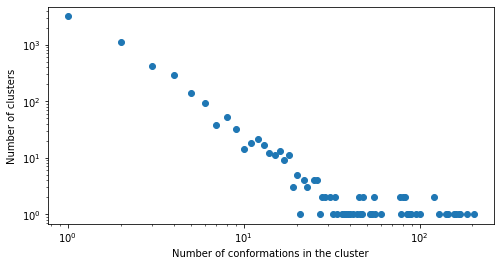

In [22]:
#@title
clustsizes = []
for motif in motifs:
    for clust in clusters[motif].values():
        clustsizes.append(len(clust))
x, y = np.unique(clustsizes, return_counts=True)
        
fig = plt.figure(figsize=(8,4))
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(x, y)
ax1.set_xscale("log")
ax1.set_yscale("log")

fig.text(0.055, 0.5, "Number of clusters", va='center', rotation='vertical')
plt.xlabel("Number of conformations in the cluster")
plt.show()